<a href="https://colab.research.google.com/github/riyalguha/IMDB_sentiment-analysis/blob/main/movie_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing all the libraries

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.9 MB/s eta 0:00:00


In [3]:
!pip install official.nlp

ERROR: Could not find a version that satisfies the requirement official.nlp (from versions: none)
ERROR: No matching distribution found for official.nlp


In [4]:
!pip install tf-models-official


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 28.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=85ea1874056c01c41560b99914d6b8cb33ed266c8bef9b68a8997a4075416f2c
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [5]:
import datetime
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from google.cloud import aiplatform
from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel("ERROR")

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


## Downloading the Dataset

In [7]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

path = "/content"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1.tar.gz", url, untar=True, cache_dir=path, cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

train_dir = os.path.join(dataset_dir, "train")

remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)


84125825/84125825 [==============================] - 2s 0us/step


In [8]:
AUTOTUNE  = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "/aclImdb/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset = "training",
    seed = seed
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size = AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path+"/aclImdb/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset = "validation",
    seed = seed
)

val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path+"/aclImdb/test",
    batch_size = batch_size
)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [9]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f"Review: {text_batch.numpy()[i]}")
        label = label_batch.numpy()[i]
        print(f"Label : {label} ({class_names[label]})")

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Loading the BERT model from Tensorflow Hub

In [10]:
# defining the URL of the smallBERT model to use
tfhub_handle_encoder = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
)

# defining the corresponding preprocessing model for the BERT model above
tfhub_handle_preprocess = (
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
)

print(f"BERT model selected           : {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Preprocessing the Text

In [11]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [12]:
text_test = ["this is such an amazing movie!"]
text_preprocessed = bert_preprocess_model(text_test)

# This print box will help you inspect the keys in the pre-processed dictionary
print(f"Keys       : {list(text_preprocessed.keys())}")

# 1. input_word_ids is the ids for the words in the tokenized sentence
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')

# 2. input_mask is the tokens which we are masking (masked language model)
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')

# 3. input_type_ids is the sentence id of the input sentence.
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using the BERT Model

In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
bert_results = bert_model(text_preprocessed)

print(f"Loaded BERT: {tfhub_handle_encoder}")
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611874  0.3667385   0.1523372   0.6550446
  0.9681154  -0.94862705  0.0021616  -0.9877732   0.06842716 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894634   0.34321257  0.33231494 ...  0.21300837  0.7102077
  -0.05771141]
 [-0.28742063  0.31981015 -0.23018579 ...  0.58455044 -0.21329722
   0.72692055]
 [-0.66157013  0.6887687  -0.87433    ...  0.10877256 -0.26173246
   0.47855335]
 ...
 [-0.2256114  -0.2892561  -0.0706443  ...  0.47565973  0.83277154
   0.40025324]
 [-0.29824266 -0.27473152 -0.05450485 ...  0.48849776  1.0955359
   0.18163376]
 [-0.4437817   0.00930699  0.07223739 ...  0.17290172  1.1833248
   0.07898028]]



* pooled_output to represent each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.

* sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.

* encoder_outputs are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.



## Defining The BERT Model

In [15]:
def build_classifier_model(dropout_rate=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name="preprocessing"
    )
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name="BERT_encoder"
    )
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name="classifier")(net)
    return tf.keras.Model(text_input, net)


# Let's check that the model runs with the output of the preprocessing model.
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.19841193]], shape=(1, 1), dtype=float32)


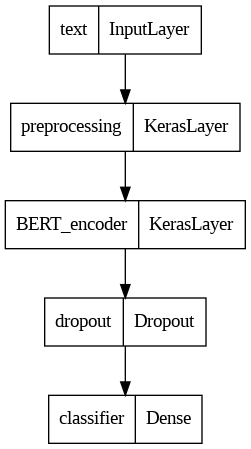

In [16]:
tf.keras.utils.plot_model(classifier_model)

## Model Training

In [17]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

In [18]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw",
)

## Compiling the Model and Training

In [19]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:
print(f"Training model with {tfhub_handle_encoder}")
history = classifier_model.fit(
    x=train_ds, validation_data=val_ds, epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 171s 259ms/step - loss: 0.4927 - binary_accuracy: 0.7484 - val_loss: 0.3861 - val_binary_accuracy: 0.8320
Epoch 2/5
625/625 [==============================] - 162s 259ms/step - loss: 0.3295 - binary_accuracy: 0.8587 - val_loss: 0.3813 - val_binary_accuracy: 0.8490
Epoch 3/5
625/625 [==============================] - 162s 260ms/step - loss: 0.2539 - binary_accuracy: 0.8976 - val_loss: 0.3895 - val_binary_accuracy: 0.8530
Epoch 4/5
625/625 [==============================] - 165s 265ms/step - loss: 0.1912 - binary_accuracy: 0.9276 - val_loss: 0.4510 - val_binary_accuracy: 0.8474
Epoch 5/5
625/625 [==============================] - 161s 258ms/step - loss: 0.1495 - binary_accuracy: 0.9455 - val_loss: 0.4867 - val_binary_accuracy: 0.8538


## Evaluate the Model

In [21]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 91s 117ms/step - loss: 0.4674 - binary_accuracy: 0.8569
Loss: 0.46737489104270935
Accuracy: 0.8568800091743469


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


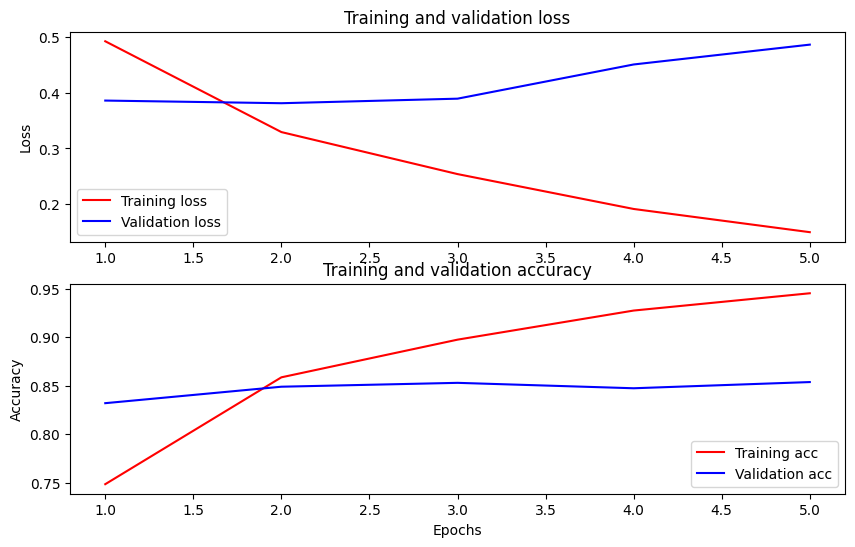

In [22]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, "r", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
# plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

In [24]:
dataset_name = "imdb"
saved_model_path = "./{}_bert".format(dataset_name.replace("/", "_"))
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(saved_model_path, TIMESTAMP)

classifier_model.save(EXPORT_PATH, include_optimizer=False)

In [25]:
reloaded_model = tf.saved_model.load(EXPORT_PATH)

In [26]:
def print_my_examples(inputs, results):
    result_for_printing = [
        f"input: {inputs[i]:<30} : score: {results[i][0]:.6f}"
        for i in range(len(inputs))
    ]
    print(*result_for_printing, sep="\n")
    print()


examples = [
    "this is such an amazing movie!",  # this is the same sentence tried earlier
    "The movie was great!",
    "The movie was meh.",
    "The movie was okish.",
    "The movie was terrible...",
]

reloaded_results = reloaded_model(tf.constant(examples))
original_results = classifier_model(tf.constant(examples))

print("Results from the saved model:")
print_my_examples(examples, reloaded_results)
print("Results from the model in memory:")
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999554
input: The movie was great!           : score: 0.996025
input: The movie was meh.             : score: 0.911153
input: The movie was okish.           : score: 0.042586
input: The movie was terrible...      : score: 0.001503

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999554
input: The movie was great!           : score: 0.996025
input: The movie was meh.             : score: 0.911153
input: The movie was okish.           : score: 0.042586
input: The movie was terrible...      : score: 0.001503

